<a href="https://colab.research.google.com/github/mikster36/PDwebApp/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf


## Data Preparation

Handwriting database consists of 62 PWP (People with Parkinson) and 15 healthy individuals. Three types of recordings (Static Spiral Test, Dynamic Spiral Test and Stability Test) are taken.
<br><br>
Dataset is delimited as CSV values as follows;
<br>
X ; Y; Z; Pressure; GripAngle; Timestamp; TestID

----------------
Test ID: <br>
0: Static Spiral Test ( Draw on the given spiral pattern) <br>
1: Dynamic Spiral Test ( Spiral pattern will blink in a certain time, so subjects need to continue on their draw) <br>
2: Circular Motion Test (Subjectd draw circles around the red point)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
directory = "/content/drive/MyDrive/PARKINSON_HW/hw_dataset/"

Mounted at /content/drive


In [3]:
cols = ('x', 'y', 'z', 'Pressure', 'GripAngle', 'Timestamp', 'TestID')    

def to_df(path: str):                                                           # converts .txt to DataFrame objects
  df = pd.read_csv(directory + path, sep=";", names=cols)
  df = df[df.TestID == 0]                                                       # only focusing on static spiral test (SST)
  df = df.drop(['z', 'Pressure', 'GripAngle', 'Timestamp', 'TestID'],           # info only collectable using drawing tablet, unable to attain this data via web app
                  axis=1)
  return df

In [4]:
def to_img(df):
  x_max = 800
  y_max = 450
  img = np.full((y_max + 1, x_max + 1, 3), [255, 255, 255])
  for i in range(df.x.size):
    x = df.x[i]
    y = 450 - df.y[i]
    img[y][x] = [0, 0, 0]
  return img

In [5]:
def to_tf(img):
  t = tf.constant(img, dtype=tf.float32)
  t /= 255.0                                                               
  return t


In [6]:
imgs = list()
labels = list()
for dir in os.listdir(directory):                                               
  if os.path.isdir(directory + dir):
    for file in os.listdir(directory + dir):
      f = os.path.join(dir, file)
      img = to_tf(to_img(to_df(f)))
      if "control" in f:
        imgs.append(img)
        labels.append(0)                                                        # assign 0 for healthy label
      else:
        imgs.append(img)
        labels.append(1)                                                        # assign 1 for Parkinson's label

In [7]:
imgs = np.array([np.array(val) for val in imgs])
labels = np.asarray(labels)

##Building the Model

In [8]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, 
                                                                    labels, 
                                                                    test_size=0.2, 
                                                                    random_state=2)

In [21]:
augmented_data = tf.keras.Sequential([tf.keras.layers.RandomFlip(),
                                      tf.keras.layers.RandomRotation((0, 2))])
model = tf.keras.models.Sequential([tf.keras.layers.Rescaling(scale=1, input_shape=(451, 801, 3)),
                                    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
                                    tf.keras.layers.MaxPooling2D(),
                                    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                                    tf.keras.layers.MaxPooling2D(),
                                    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                                    tf.keras.layers.MaxPooling2D(),
                                    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
                                    tf.keras.layers.MaxPooling2D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(2, activation='softmax')])

In [25]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [26]:
history = model.fit(train_imgs, train_labels, epochs=15)

Epoch 1/15
2/2 [==============================] - 1s 243ms/step - loss: 0.9072 - accuracy: 0.8000
Epoch 2/15
2/2 [==============================] - 0s 229ms/step - loss: 0.2824 - accuracy: 0.9000
Epoch 3/15
2/2 [==============================] - 0s 228ms/step - loss: 0.2487 - accuracy: 0.8667
Epoch 4/15
2/2 [==============================] - 0s 234ms/step - loss: 0.2548 - accuracy: 0.8667
Epoch 5/15
2/2 [==============================] - 0s 231ms/step - loss: 0.2309 - accuracy: 0.8667
Epoch 6/15
2/2 [==============================] - 0s 231ms/step - loss: 0.2045 - accuracy: 0.8667
Epoch 7/15
2/2 [==============================] - 0s 231ms/step - loss: 0.1792 - accuracy: 0.8833
Epoch 8/15
2/2 [==============================] - 0s 230ms/step - loss: 0.1407 - accuracy: 0.9167
Epoch 9/15
2/2 [==============================] - 0s 233ms/step - loss: 0.0891 - accuracy: 1.0000
Epoch 10/15
2/2 [==============================] - 0s 232ms/step - loss: 0.0961 - accuracy: 0.9833
Epoch 11/15
2/2 [==

##Testing the Model

In [27]:
model.evaluate(test_imgs, test_labels)


1/1 [==============================] - 0s 240ms/step - loss: 0.5050 - accuracy: 0.8750


[0.5049737095832825, 0.875]

1/1 [==============================] - 0s 123ms/step


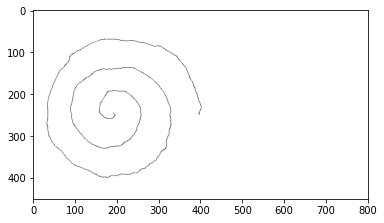

Is healthy
0.15 chance they have PD
0.85 chance they are healthy


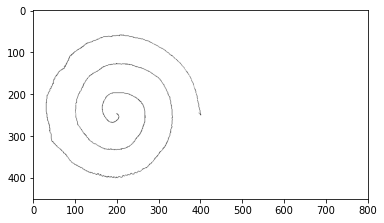

Is healthy
0.15 chance they have PD
0.85 chance they are healthy


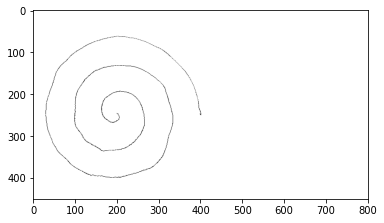

Is healthy
0.03 chance they have PD
0.97 chance they are healthy


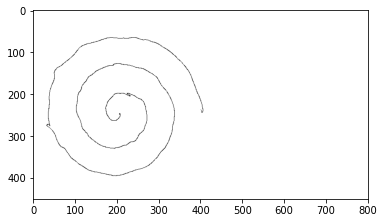

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


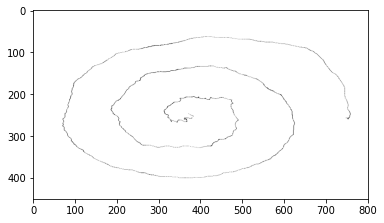

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


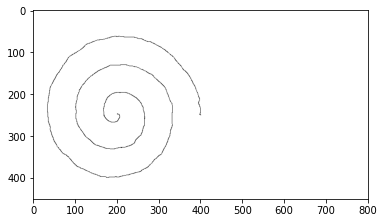

Is healthy
0.05 chance they have PD
0.95 chance they are healthy


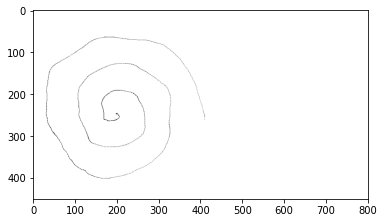

Is healthy
0.98 chance they have PD
0.02 chance they are healthy


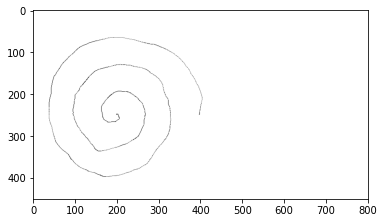

Is healthy
0.96 chance they have PD
0.04 chance they are healthy


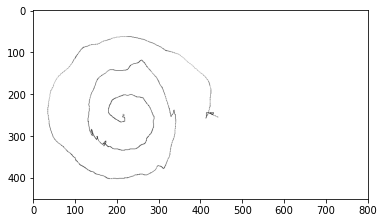

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


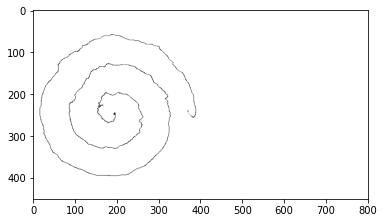

Has Parkinsons
0.99 chance they have PD
0.01 chance they are healthy


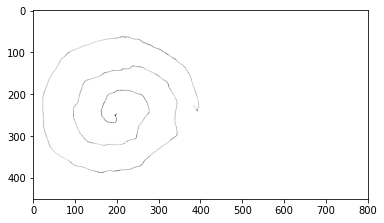

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


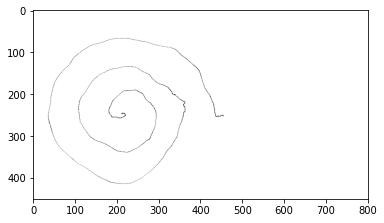

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


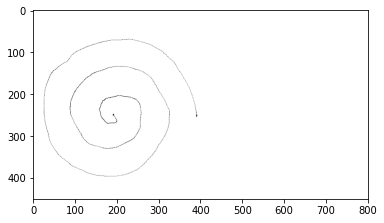

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


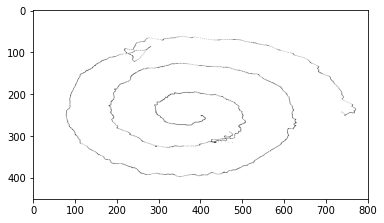

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


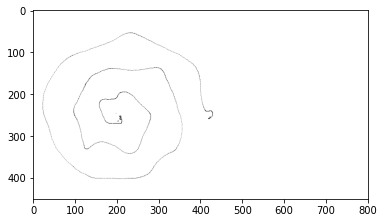

Has Parkinsons
1.00 chance they have PD
0.00 chance they are healthy


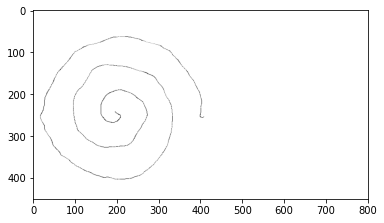

Has Parkinsons
0.79 chance they have PD
0.21 chance they are healthy


In [28]:
classifications = model.predict(test_imgs)
for i in range(16):
  plt.imshow(test_imgs[i])
  plt.show()
  if test_labels[i] == 1:
    print("Has Parkinsons")
  else:
    print("Is healthy")
  print("{:.2f}".format(classifications[i][1]), "chance they have PD")
  print("{:.2f}".format(classifications[i][0]), "chance they are healthy")

## References


1.Isenkul, M.E.; Sakar, B.E.; Kursun, O. . 'Improved spiral test using digitized graphics tablet for monitoring Parkinson's disease.' The 2nd International Conference on e-Health and Telemedicine (ICEHTM-2014), pp. 171-175, 2014.
<br>
2.Erdogdu Sakar, B., Isenkul, M., Sakar, C.O., Sertbas, A., Gurgen, F., Delil, S., Apaydin, H., Kursun, O., 'Collection and Analysis of a Parkinson Speech Dataset with Multiple Types of Sound Recordings', IEEE Journal of Biomedical and Health Informatics, vol. 17(4), pp. 828-834, 2013.